## Imports

In [1]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import os

from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

sys.path.insert(0, '../../../Utils/')

from SVC_Utils import *
import models
from train import *
from metrics import * 

print("Python: %s" % sys.version)
print("Pytorch: %s" % torch.__version__)

# determine device to run network on (runs on gpu if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Python: 3.6.5 (default, Jun 21 2018, 23:07:39) 
[GCC 5.4.0 20160609]
Pytorch: 0.4.0


## Hyperparameters

In [2]:
n_epochs = 25
batch_size = 128
lr = 0.001
k = 3

target_net_type = models.mlleaks_cnn
shadow_net_type = models.mlleaks_cnn

# Load SVM

In [3]:
target=joblib.load('maxacc_CIFAR10')
print(target)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=180, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(-1, 1))), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


## Load CIFAR10

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


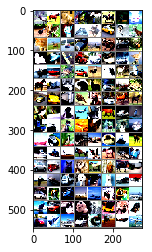

In [4]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    

    #torchvision.transforms.RandomRotation(10),
    #torchvision.transforms.RandomHorizontalFlip(),
    #torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    #torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))  

In [5]:

total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

#attack_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_train_sampler, num_workers=1)

#attack_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=32, sampler=shadow_out_sampler, num_workers=1)
target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = target_net_type().to(device)
target_net.apply(models.weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type().to(device)
shadow_net.apply(models.weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = models.mlleaks_mlp(n_in=k).to(device)
attack_net.apply(models.weights_init)

#attack_loss = nn.BCEWithLogitsLoss()
attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)


In [6]:
#train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs, classes=classes)
#joblib.dump(shadow_net, 'shadow_net_CIFAR10')

In [7]:
#train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, n_epochs=50, k=k)
#joblib.dump(attack_net, 'attack_net_CIFAR10')

In [8]:
shadow_net=joblib.load('shadow_net_CIFAR10')
attack_net=joblib.load('attack_net_CIFAR10')

#train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)

print(train_posteriors.shape)
print(mini_batch_size)
print(out_posteriors.shape)

train_unsqueezed=attack_net(train_top_k)#.sum().item()
train_predictions = torch.squeeze(attack_net(train_top_k))
print(train_predictions.shape)
for i in range(len(train_predictions)):
    if train_predictions[i]>.5:
        print(i)


In [15]:
eval_attack_net(attack_net, target, target_train_loader, target_out_loader, k)

accuracy = 50.00, precision = 0.00, recall = 0.00


print(attack_net)

print(shadow_net)

In [26]:
  for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train_loader, target_out_loader)):


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs.to(device), out_imgs.to(device)
        
        #[mini_batch_size x num_classes] tensors, (0,1) probabilities for each class for each sample)
        if type(target) is Pipeline:
            traininputs=train_imgs.view(train_imgs.shape[0], -1)
            outinputs=out_imgs.view(out_imgs.shape[0], -1)
            
            train_posteriors=torch.from_numpy(target.predict_proba(traininputs))
            out_posteriors=torch.from_numpy(target.predict_proba(outinputs))
            
        else:
            train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
            out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)
        

        #[k x mini_batch_size] tensors, (0,1) probabilities for top k probable classes
        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k]
        if type(target) is not Pipeline:
            train_top_k.clone().to(device)

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone().to(device)


        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)

        #
        train_lbl = torch.ones(mini_batch_size).to(device)
        out_lbl = torch.zeros(mini_batch_size).to(device)


        train_predictions = torch.squeeze(attack_net(train_top_k))
        out_predictions = torch.squeeze(attack_net(out_top_k))



RuntimeError: Expected object of type torch.cuda.FloatTensor but found type torch.DoubleTensor for argument #4 'mat1'

In [18]:
t=train_predictions; print(t)

tensor([ 0.1125,  0.1497,  0.1427,  0.1143,  0.1329,  0.1507,  0.1381,
         0.1540,  0.1692,  0.1267,  0.1154,  0.1529,  0.1442,  0.1149,
         0.1155,  0.1017,  0.1398,  0.1075,  0.1383,  0.1565,  0.1170,
         0.1237,  0.1307,  0.1307,  0.1324,  0.1608,  0.1581,  0.1439,
         0.1229,  0.1213,  0.1323,  0.1197,  0.1098,  0.1305,  0.1248,
         0.1340,  0.1525,  0.1526,  0.1411,  0.1244,  0.1321,  0.1166,
         0.1297,  0.1408,  0.1291,  0.1264,  0.1293,  0.1279,  0.1357,
         0.0984,  0.1618,  0.1415,  0.1213,  0.1354,  0.1374,  0.1450,
         0.1213,  0.1153,  0.1523,  0.1121,  0.1518,  0.1560,  0.1577,
         0.1287,  0.1162,  0.1093,  0.1335,  0.1507,  0.1388,  0.1160,
         0.1354,  0.1815,  0.1170,  0.1433,  0.1383,  0.1704,  0.1439,
         0.1526,  0.1280,  0.1433,  0.1479,  0.1018,  0.1304,  0.1263], device='cuda:0')


In [ ]:
if type(target) is not Pipeline:
    print(target)